In [1]:
# imports
import math
import datetime
import numpy as np
#import pytz
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
#from mpl_toolkits.axes_grid1 import host_subplot
import pandas as pd
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['figure.figsize'] = [15, 4]

# 1.  Environmental Data

This notebook can either be used with environmental data from the pvgis database or with measured data.

## 1.2 PVGIS data

The PVGIS database should be used prior to builduing the greenhouse. The environmental data specific to your location can be downloaded at:
https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html#MR. For the configurator to work properly choose hourly data. For the mounting type choose fixed angle and download the data as csv file for a slope angle of 0°, 15°, 30°, ..., 90°. Then combine the downloaded data into one csv file. You can find an example file with the name 'Timeseries_48.006_8.038_SA_0_90deg_0deg_2014_2016.csv' in the /data directory of this repository. 

In [2]:
# read irradiance and weather data from csv file and create pandas dataframe
pv_gis_ts = pd.read_csv('data/Timeseries_48.006_8.038_SA_0_90deg_0deg_2014_2016.csv',skiprows=8,skipfooter=10,sep=',',engine='python');
pv_gis_ts["time"] = pd.to_datetime(pv_gis_ts["time"],format="%Y%m%d:%H%M") # parse date
pv_gis_ts = pv_gis_ts.set_index('time') # convert to timeseries
pv_gis_ts.head() # show first rows of dataframe

,G(0),G(15),G(30),G(45),G(60),G(75),G(90),H_sun,T2m,WS10m,Int
time,,,,,,,,,,,
2014-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.09,4.37,0.0
2014-01-01 01:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38,3.87,0.0
2014-01-01 02:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.66,3.36,0.0
2014-01-01 03:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95,2.86,0.0
2014-01-01 04:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.06,2.72,0.0


# Geometry

In [6]:
def generate_frame_patch(window_angle,window_width,frame_height_front,frame_width_top, window_length):
    global window_area, frame_width, frame_height_back, greenhouse_volume, insulated_area
    
    #calculation of residual lengths
    window_area = window_width * window_length
    frame_width = frame_width_top + window_width * math.cos(window_angle * math.pi / 180)
    frame_height_back = frame_height_front + window_width * math.sin(window_angle * math.pi / 180)

    #calculation of areas
    front_area = frame_width * frame_height_front
    back_area = frame_width * frame_height_back
    side_area = (frame_width * frame_height_front) + (frame_width_top * (frame_height_back - frame_height_front)) + 1/2 * (frame_width - frame_width_top) * (frame_height_back - frame_height_front)
    top_area = frame_width_top * window_length
    bottom_area = frame_width * window_length
    total_area = window_area + front_area + back_area + 2*side_area + top_area + bottom_area
    insulated_area = total_area - window_area
    #calculation of volume
    greenhouse_volume = side_area * window_length

    verts = [
       (0., 0.),
       (frame_width, 0),
       (frame_width, frame_height_front),
       (frame_width_top,frame_height_back),
       (0, frame_height_back),
       (0., 0.),
    ]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='white', lw=2)
    return patch

def generate_storage_patch(shape, diameter, height, width, depth,offset):
    """input: shape ('Cylinder', 'Cuboid') and either (height, diameter) or (height, width, depth)"""
    global storage_volume, storage_surface_absorption, storage_surface_emission
    if shape == 'Cylinder':
        storage_volume = math.pi * math.pow((diameter/2),2) * height # in m^3
        storage_surface_emission = math.pi * diameter * height
        storage_surface_absorption = diameter * height
    else:
        storage_volume = width * depth * height # in m^3
        storage_surface_absorption = width * height # m^2 front
        storage_surface_emission = 2*depth*height + width*height + width*depth # m^2 both sides, front, top
        diameter = depth
    verts = [
        (0.,0.+offset), # bottom left
        (diameter,offset), # bottom right
        (diameter,height+offset), # top right
        (0.,height+offset), # top left
        (0.,0.+offset), # close
    ]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts,codes)
    patch = patches.PathPatch(path,facecolor='blue', lw=2)

    return patch, diameter, height+offset

def generate_insulation(insulation_width, window_angle,window_width,frame_height_front,frame_width_top, window_length):
    frame_width = frame_width_top + window_width * math.cos(window_angle * math.pi / 180)
    frame_height_back = frame_height_front + window_width * math.sin(window_angle * math.pi / 180)
    verts = [
        (-insulation_width,-insulation_width), #left bottom
        (frame_width+insulation_width, -insulation_width), # right bottom
        (frame_width+insulation_width, frame_height_front- (math.tan(window_angle* math.pi / 180)*insulation_width)), #right top
        (frame_width_top-(insulation_width/math.tan(window_angle* math.pi / 180)),frame_height_back+insulation_width),
        (-insulation_width, frame_height_back+insulation_width), #left top
        (0,0)
    ]
    
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='orange', lw=2, hatch = '/')
    return patch, insulation_width

def generate_soil(frame_width_top, window_width, window_angle, frame_height_front):
    frame_width = frame_width_top + window_width * math.cos(window_angle * math.pi / 180)
    verts = [
       (0., 0.),
       (frame_width, 0),
       (frame_width, frame_height_front),
       (0, frame_height_front),
       (0., 0.),
    ]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts,codes)
    patch = patches.PathPatch(path,facecolor='brown',lw=2, hatch = 'x')
    return patch

def plot_geometry(window_angle,window_width,frame_height_front,frame_width_top, window_length,storage_shape,storage_diameter, storage_height,storage_width, insulation_width, storage_depth):
    global insulation_width_global, storage_volume
    insulation_patch, insulation_width_global = generate_insulation(insulation_width, window_angle,window_width,frame_height_front,frame_width_top, window_length)
    frame_patch = generate_frame_patch(window_angle,window_width,frame_height_front,frame_width_top, window_length)
    storage_patch, storage_annotation_x, storage_annotation_y = generate_storage_patch(shape = storage_shape, diameter = storage_diameter, height = storage_height, width = storage_width, depth = storage_depth,offset = 0)
    #soil_patch = generate_soil(frame_width_top, window_width, window_angle, frame_height_front)
    
    fig, (ax) = plt.subplots()
    plt.grid(True)
    ax.add_patch(insulation_patch)
    ax.add_patch(frame_patch)
    ax.add_patch(storage_patch)
    #ax.add_patch(soil_patch)

    # annotion for window
    ax.annotate('Window- \nArea: {:.2f} m^2'.format(window_area),
                xy=(frame_width - ((math.cos(window_angle * math.pi / 180)*window_width)/2), 
                    frame_height_front + ((math.sin(window_angle * math.pi / 180)*window_width)/2)), xycoords='data',
                xytext=(frame_width+insulation_width*2, frame_height_back-0.2), textcoords='data',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="fancy",
                                connectionstyle="arc3,rad=0.3"))
    if storage_height != 0:
        # annotion for thermal energy storage
        ax.annotate('TES-\nVolume: {:.2f} L\nArea-abs.: {:.2f} m^2\nArea-emi.:{:.2f} m^2'.format(storage_volume*1000,storage_surface_absorption,storage_surface_emission),
                    xy=(storage_annotation_x, storage_annotation_y) , xycoords='data',
                    xytext=(frame_width+insulation_width*2, frame_height_back), textcoords='data',
                    bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    connectionstyle="arc3,rad=0.3"))

    # annotion for the frame
    ax.annotate('Frame-\nVolume: {:.2f} m^3\n Area: {:.2f} m^2'.format(greenhouse_volume, insulated_area),
                xy=(frame_width + insulation_width, 0) , xycoords='data',
                xytext=(frame_width+insulation_width*2, frame_height_back-0.6), textcoords='data',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="fancy",
                                connectionstyle="arc3,rad=0.3"))
    
    ax.set_ylabel('Height in Meters')
    ax.set_xlabel('Width in Meters')
    ax.axis('equal')
    fig.set_size_inches(5, 5)
    plt.axis('off')
    plt.show()


# Calculations


In [54]:
# DEFINE MATERIAL CONSTANTS
transmittance_glazing = 0.84 
c_P_air = 1.012                             # kJ/kg*K specific heat capacity air
c_P_water = 4.184                           # kJ/kg*K specific heat capacity water
c_P_wood = 2.301                            # kJ/kg*K specific heat capacity wood
density_air = 1.225                         # kg/m^3
density_water = 1000                        # kg/m^3
density_wood = 500                          # kg/m^3
dyn_viscosity_air = 18.2 * math.pow(10 ,-6) # Pa*s
lamda_air = 0.02587                         # W/m*K
lamda_wood = 0.113                          # W/m*K
absorptance_storage = 0.97                  #          black paint
absorptance_wood = 0.85
storage_thickness = 0.002                   # m
wood_thickness = 0.025                       # m

#DEFINE HEAT FLOW ARRAYS
heat_flow_trans_insulation = [0]
heat_flow_amb_to_greenhouse_window = [0]
heat_flow_ventilation = [0]
heat_flow_radiative_gain_air = [0]
heat_flow_radiative_gain_storage_from_sun = [0]
heat_flow_transmission_storage_air = [0]
heat_flow_balance_storage = [0]
heat_flow_balance = [0]

temp_greenhouse = [0]
temp_storage = [0]
temp_wood = [0]

def calc_delta_temperature(heat_flow, d_time, c_P, density, volume):
    """ calculates the temperature difference of the medium from start to end of the time slot """
    delta_temp = heat_flow * d_time / (c_P * 1000 * density * volume)
    return delta_temp

def calc_radiative_heat_gain(irradiation, transmittance, area, absorptance = 1):
    heat_flow = irradiation * transmittance * absorptance * area
    return heat_flow

def calc_u_value_conductive(thickness, thermal_conductivity):
    u_value = thermal_conductivity / thickness
    return u_value

def calc_u_value_convective_free_air(temp_in, temp_out):
    u_value = 1.3 * math.pow((abs(temp_in - temp_out)), 0.33) + 0.000001 # avoid devision by zero
    return u_value

def calc_u_value_convective_free_water(temp_in, temp_out):
    #print(temp_in, temp_out)
    u_value = 120 * math.pow((abs(temp_in - temp_out)), 0.33) + 0.000001 # avoid devision by zero
    return u_value

def calc_u_value_convective_forced(spec_length, wind_speed):
    if wind_speed == 0:
        wind_speed = 0.1 # avoid devision by zero 
    Re = wind_speed * spec_length * density_air / dyn_viscosity_air
    Pr = dyn_viscosity_air * c_P_air / lamda_air * 1000
    Nu = math.pow(0.441 * Re * math.pow(Pr,0.667) + (math.pow(Re,1.6) * math.pow(Pr,2)) / math.pow((27.027 + 66.027 * math.pow(Re,-0.1) * (math.pow(Pr,0.667) - 1)),2),0.5)
    u_value = Nu * lamda_air / spec_length
    return u_value

def calc_u_value_total(*args):
    r_total = 0
    for u_value in args:
        r_total = r_total + 1/u_value 
    return 1 / r_total

def calc_transmission(u_value, area, temp_out, temp_in):
    ''' calculates the heat flow caused by conduction and convection '''
    heat_flow = u_value * area * (temp_in - temp_out)
    return heat_flow

def calc_ventilation_losses(volume,ventilation_number,temp_in, temp_out):
    heat_flow = c_P_air * density_air * volume * ventilation_number * (temp_in - temp_out)/3600 * 1000
    return heat_flow

# uncomment for pvgis data
'''
def reset_timing(start_date, end_date):
    global temp_amb_data, wind_speed_data, irradiation_data
    # select data range by date
    #df_range = df.loc['2016-01-26 06:00:00':'2016-01-29 06:00:00']
    df_range = pv_gis_ts.loc[str(start_date):str(end_date)]
    df_range = df_range.resample('60S').asfreq()
    df_range = df_range.interpolate(method = 'linear')

    temp_amb_data = df_range['T2m'].to_numpy()
    wind_speed_data = df_range['WS10m'].to_numpy()
    irradiation_data = {
        'Horiz' : df_range['G(0)'].to_numpy(),
        '15'    : df_range['G(15)'].to_numpy(),
        '30'    : df_range['G(30)'].to_numpy(),
        '45'    : df_range['G(45)'].to_numpy(),
        '60'    : df_range['G(60)'].to_numpy(),
        '75'    : df_range['G(75)'].to_numpy(),
        '90'    : df_range['G(90)'].to_numpy()
    }
    return df_range.index
'''
# uncomment for measured data
def reset_timing(start_date, end_date):
    global temp_amb_data, wind_speed_data, irradiation_data
    
    # select data range by date
    df_range = measurements.loc[str(start_date):str(end_date)]
    temp_amb_data = df_range['ambient'].to_numpy()
    wind_speed_data = df_range['wind_speed'].to_numpy()
    irradiation_data = {
        'Horiz' : df_range['GHI'].to_numpy(),
        #'15'    : df_range['irradiance'].to_numpy(),
        #'30'    : df_range['irradiance'].to_numpy(),
        #'45'    : df_range['irradiance'].to_numpy(),
        '60'    : df_range['G60'].to_numpy(),
        #'75'    : df_range['irradiance'].to_numpy(),
        '90'    : df_range['G90'].to_numpy()
    }
    return df_range.index

def calc_results(start_date, end_date,**kwargs):
    #definition of global variables in the function
    global irradiation, storage_surface_absorption, window_area, temp_amb_data, wind_speed_data
    global heat_flow_amb_to_greenhouse_insulation,heat_flow_amb_to_greenhouse_insulation, heat_flow_amb_to_greenhouse_window
    global heat_flow_ventilation, heat_flow_radiative_gain_air_from_sun, heat_flow_radiative_gain_storage_from_sun
    global heat_flow_transmission_storage_air, heat_flow_balance_storage, heat_flow_balance, temp_greenhouse, temp_storage , temp_wood

    time = reset_timing(start_date = start_date, end_date = end_date)
    
    for k,v in kwargs.items():
        #write lamdas insulation due to insulation_type
        if k =='insulation_type' and v == 'Sheepwool':
            insulation_lamda = 0.04 #W/m*K
        if k =='insulation_type' and v == 'Calciumsilicate':
            insulation_lamda = 0.07 #W/m*K
        if k =='insulation_type' and v == 'Wood chips':
            insulation_lamda = 0.055 #W/m*K
        #write u-value glazing due to window_type
        if k =='window_type' and v == 'Single glazing':
            window_u_value = 5 #W/m^2*K
        if k =='window_type' and v == 'Double glazing':
            window_u_value = 3 #W/m^2*K
        if k =='window_type' and v == 'Triple glazing':
            window_u_value = 0.6 #W/m^2*K
        if k =='window_type' and v == 'Plexiglass':
            window_u_value = 18 #W/m^2*K
        if k =='window_type' and v == 'Double-wall sheets':
            window_u_value = 0.9 #W/m^2*K
        #write lamda storage due to storage_material
        if k == 'storage_material' and v == 'Aluminium':
            storage_lamda = 236 #W/m*K
        if k == 'storage_material' and v == 'PVC':
            storage_lamda = 0.16 #W/m*K
        if k == 'storage_material' and v == 'Steel':
            storage_lamda = 80 #W/m*K
        #write irradiance due to window_angle
        if k == 'window_angle':
            irradiation_window_data = irradiation_data[str(v)]
        if k == 'ventilation_number':
            ventilation_number = v
        if k == 'insulation_width':
            insulation_width = v
        if k == 'window_width':
            window_width = v

    # define time step of the simulation
    time_step = 60 # sec -> time step at which the simulation should run | must be equal to timestep of input data

    # PREPARE ENV DATA

    # stretch the environmental data to the simulation timesteps
    #temp_amb = np.repeat(temp_amb_data,time_step)
    #wind_speed = np.repeat(wind_speed_data,time_step)
    irradiation_soil = irradiation_data['Horiz']
    irradiation_storage = irradiation_data['90']
    irradiation_window = irradiation_window_data
    
    #reset the arrays to zero for the new calculations
    heat_flow_trans_insulation = [0]
    heat_flow_trans_window = [0]
    heat_flow_ventilation = [0]
    heat_flow_radiative_gain_storage = [0]
    heat_flow_trans_storage = [0]
    heat_flow_trans_wood = [0]
    heat_flow_conv_wood = [0]
    heat_flow_radiative_gain_wood = [0]

    heat_flow_balance_storage = [0]
    heat_flow_balance_wood = [0]
    heat_flow_balance = [0]
    
    # uncomment for pvgis data
    #temp_wood = [temp_amb_data[0]]
    #temp_greenhouse = [temp_amb_data[0]]
    #temp_storage = [temp_amb_data[0]]
    
    # uncomment for measured data
    temp_wood = [measurements['gh_mean'].loc[str(start_date)][0]]
    temp_storage = [measurements['tank_mean'].loc[str(start_date)][0]]
    temp_greenhouse = [measurements['gh_mean'].loc[str(start_date)][0]]

# CALCULATE HEAT FLOWS
    for t,temp_amb, irrad_soil, irrad_storage, irrad_window, wind in zip(time,temp_amb_data, irradiation_soil, irradiation_storage, irradiation_window, wind_speed_data):

        #calculate u_value total for window
        u_conv_1 = calc_u_value_convective_free_air(temp_in = temp_greenhouse[-1], temp_out = temp_amb)
        u_cond = window_u_value
        u_conv_2 = calc_u_value_convective_forced(spec_length = window_width, wind_speed = wind)
        u_value_window = calc_u_value_total(u_conv_1, u_cond, u_conv_2)

        # calculate transmission through window
        heat_flow_trans_window_temp = calc_transmission(u_value = u_value_window,
                                                                        area = window_area,
                                                                        temp_out = temp_amb,
                                                                        temp_in = temp_greenhouse[-1])
        heat_flow_trans_window.append(heat_flow_trans_window_temp)

        #calc ventilation losses
        heat_flow_ventilation_temp = calc_ventilation_losses(volume = greenhouse_volume,
                                                             ventilation_number = ventilation_number,
                                                             temp_in = temp_greenhouse[-1],
                                                             temp_out = temp_amb)
        heat_flow_ventilation.append(heat_flow_ventilation_temp)

        #calculate radiative heat flow gain from the sun to the storage tank
        heat_flow_radiative_gain_storage_temp = calc_radiative_heat_gain(irradiation = irrad_storage,
                                                        transmittance = transmittance_glazing,
                                                        area = storage_surface_absorption,
                                                        absorptance = absorptance_storage)
        heat_flow_radiative_gain_storage.append(heat_flow_radiative_gain_storage_temp)

        #calculate u_value total for storage
        u_conv_1 = calc_u_value_convective_free_water(temp_in = temp_storage[-1], temp_out = temp_greenhouse[-1])
        u_cond = calc_u_value_conductive(thickness = storage_thickness, thermal_conductivity = storage_lamda)
        u_conv_2 = calc_u_value_convective_free_air(temp_in = temp_storage[-1], temp_out = temp_greenhouse[-1])
        u_value_storage = calc_u_value_total(u_conv_1, u_cond, u_conv_2)

        #calculate trasmission from storage to greenhouse
        heat_flow_trans_storage_temp = calc_transmission(u_value = u_value_storage,
                                                                        area = storage_surface_emission,
                                                                        temp_out = temp_greenhouse[-1],
                                                                        temp_in = temp_storage[-1])
        heat_flow_trans_storage.append(heat_flow_trans_storage_temp)
       
        # wood radiative gains
        heat_flow_radiative_gain_wood_temp = calc_radiative_heat_gain(irradiation = irrad_soil,
                                                        transmittance = transmittance_glazing,
                                                        area = window_area,
                                                        absorptance = absorptance_wood)
        heat_flow_radiative_gain_wood.append(heat_flow_radiative_gain_wood_temp)
        
        # calculate u_value conv free for wood
        u_conv_wood = calc_u_value_convective_free_air(temp_in = temp_wood[-1], temp_out = temp_greenhouse[-1])
      
        # wood conv losses
        heat_flow_conv_wood_temp = calc_transmission(u_value = u_conv_wood,
                                                                        area = (window_area+insulated_area)/2,
                                                                        temp_out = temp_greenhouse[-1],
                                                                        temp_in = temp_wood[-1])
        heat_flow_conv_wood.append(heat_flow_conv_wood_temp)
    
        #calculate u_value_total for insulation
        u_cond_wood = calc_u_value_conductive(thickness = wood_thickness, thermal_conductivity = lamda_wood)
        u_cond_insulation = calc_u_value_conductive(thickness = insulation_width, thermal_conductivity = insulation_lamda)
        u_conv_forced = calc_u_value_convective_forced(spec_length = frame_height_back, wind_speed = wind)
        u_value_insulation = calc_u_value_total(u_cond_wood,u_cond_insulation, u_conv_forced)

        #calc transmission through insulation
        heat_flow_trans_insulation_temp = calc_transmission(u_value = u_value_insulation,
                                                                        area = insulated_area,
                                                                        temp_out = temp_amb,
                                                                        temp_in = temp_wood[-1])
        heat_flow_trans_insulation.append(heat_flow_trans_insulation_temp)
    
        # calc heat flow balance wood
        heat_flow_balance_wood_temp = heat_flow_radiative_gain_wood_temp - heat_flow_trans_insulation_temp - heat_flow_conv_wood_temp
        heat_flow_balance_wood.append(heat_flow_balance_wood_temp)
        
        #calc heat flow balance storage
        heat_flow_balance_storage_temp = heat_flow_radiative_gain_storage_temp - heat_flow_trans_storage_temp
        heat_flow_balance_storage.append(heat_flow_balance_storage_temp)

        #calc heat flow balance: 
        heat_flow_balance_temp = - heat_flow_ventilation_temp - heat_flow_trans_window_temp + heat_flow_trans_storage_temp + heat_flow_conv_wood_temp
        heat_flow_balance.append(heat_flow_balance_temp)


        
        # calc_temp of wood
        temperature_wood = temp_wood[-1] + calc_delta_temperature(heat_flow = heat_flow_balance_wood_temp,
                                                                                d_time = time_step,
                                                                                c_P = c_P_wood,
                                                                                density = density_wood,
                                                                                volume = (insulated_area * wood_thickness))
        temp_wood.append(temperature_wood)
        
        # calculate temperature in the storage
        temperature_storage = temp_storage[-1] + calc_delta_temperature(heat_flow = heat_flow_balance_storage_temp,
                                                                                d_time = time_step,
                                                                                c_P = c_P_water,
                                                                                density = density_water,
                                                                                volume = storage_volume)
        temp_storage.append(temperature_storage)
        
        
        
        # calc temperature in the greenhouse
        temperature_greenhouse = temp_greenhouse[-1] + calc_delta_temperature(heat_flow = heat_flow_balance_temp,
                                                                                d_time = time_step,
                                                                                c_P = c_P_air,
                                                                                density = density_air,
                                                                                volume = greenhouse_volume)
        temp_greenhouse.append(temperature_greenhouse)

    # delete the last element of the following arrays, to make them equal size as the env data 
    temp_greenhouse.pop()
    temp_storage.pop()
    temp_wood.pop()
    heat_flow_trans_insulation.pop()
    heat_flow_trans_window.pop()

#PLOT RESULTS
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    time_plot = time
    for k,v in kwargs.items():
        if k == 'ambient_temperature' and v == True:
            ax1.plot(time_plot, temp_amb_data, label='Ambient Temperature', color='b', dashes=[6, 2])
        if k == 'irradiation_window' and v == True:
            ax2.plot(time_plot, irradiation_window, label='Irradiation window', color='y', dashes=[6, 2])
            ax2.set_ylabel('Irradiation in W/m^2')
        if k == 'irradiation_storage' and v == True:
            ax2.plot(time_plot, irradiation_storage, label='Irradiation storage', color='orange', dashes=[6, 2])
            ax2.set_ylabel('Irradiation in W/m^2')
        if k == 'wind_speed' and v == True:
            ax3 = ax1.twinx()
            ax3.spines["right"].set_position(("axes", 1.05))
            ax3.plot(time_plot, wind_speed_data, label='Wind speed ', color='lightblue')
            ax3.set_ylabel('Wind speed in m/s')
    
    ax1.plot(time_plot, temp_greenhouse, label='Greenhouse Temperature', color='r')
    ax1.plot(time_plot, temp_storage, label='Storage Temperature', color='green')
    ax1.set_ylabel('Temperature in °C')
    #ax1.set_xlabel('Time in hours')


    #fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
    fig.set_size_inches(17, 5)
    plt.show();

    return

# User Interface


In [67]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# styles
style = {'description_width': 'initial'}

# CONSTRUCTION-TAB
# Widgets for the window
window_description = widgets.HTML(value = f"<b><font color='blue'>{'Window'}</b>")
window_type = widgets.Dropdown(options=[('Single glazing'),('Double glazing'),('Triple glazing'),('Plexiglass'),('Double-wall sheets')],description='',value = 'Double glazing',style=style)
window_width = widgets.FloatSlider(min = 0.1, max = 2, value = 0.9, step = 0.01, description='Width [m]',style=style,continuous_update=False)
window_length = widgets.FloatSlider(min = 0.1,max = 2, value = 1, step = 0.01, description='Lenght [m]',style=style,continuous_update=False)
window_angle = widgets.IntSlider(min = 0,max = 75, value = 60, step = 15, description='Angle [deg]',style=style,continuous_update=False)
window_box = widgets.VBox(children=[window_description, window_type,window_length,window_width,window_angle],
                          layout={'border': '0px solid black'})

# Widgets for the insulation
insulation_description = widgets.HTML(value = f"<b><font color='blue'>{'Insulation'}</b>")
insulation_width = widgets.FloatSlider(min = 0, max = 0.3, value = 0.12, step = 0.01, description='Width [m]', style=style,continuous_update=False)
insulation_type = widgets.Dropdown(options=[('Calciumsilicate'),('Sheepwool'),('Wood chips')],description='Material:',value='Sheepwool',style=style)
insulation_box = widgets.VBox(children=[insulation_description,insulation_type,insulation_width])

# Widgets for the storage
storage_description = widgets.HTML(value = f"<b><font color='blue'>{'Thermal Energy Storage - TES'}</b>")
storage_shape = widgets.Dropdown(options=['Cylinder','Cuboid'],value='Cuboid')
storage_height = widgets.FloatSlider(min = 0, max = 2,value = 0.65, step = 0.05, description='Height [m]',style=style,continuous_update=False)
storage_diameter = widgets.FloatSlider(min = 0, max = 2,value = 0.15, step = 0.05, description='Diameter [m]',style=style,continuous_update=False)
storage_width = widgets.FloatSlider(min = 0, max = 2,value = 0.35, step = 0.05, description='Width [m]',style=style,continuous_update=False)
storage_depth = widgets.FloatSlider(min = 0, max = 2,value = 0.25, step = 0.05, description='Depth [m]',style=style,continuous_update=False)
def select_storage_geometry(shape):
    if shape == 'Cylinder':
        storage_geometry = widgets.VBox(children=[storage_height, storage_diameter])
    else:
        storage_geometry = widgets.VBox(children=[storage_height,storage_width,storage_depth])
    display(storage_geometry)
#Interactive widget to allow different widgets to be displayed dependent on the choosen shape of the storage
geometry_storage = widgets.interactive_output(select_storage_geometry, {'shape' : storage_shape})
storage_material = widgets.Dropdown(options=[('Aluminium'), ('PVC'), ('Steel')],description='Container:', value = 'PVC',style=style)
storage_box = widgets.VBox(children=[storage_description,storage_shape,geometry_storage,storage_material])

# Widgets for the soil
soil_description = widgets.HTML(value = f"<b><font color='blue'>{'Soil'}</b>")
frame_height_front = widgets.FloatSlider(min = 0.05,max = 1, value = 0.2, step = 0.05, description='Depth [m]',style=style,continuous_update=False)
 
soil_box = widgets.VBox(children=[soil_description,frame_height_front])
                                
# Widgets for the Frame / Grow area
soil_description = widgets.HTML(value = f"<b><font color='blue'>{'Frame'}</b>")
frame_width_top = widgets.FloatSlider(min = 0, max = 0.5, value = 0.3, step = 0.05, description='Width (top) [m]',style=style,continuous_update=False)
                                
construction_VBox_1 = widgets.VBox(children= [window_box,soil_box,soil_description,frame_width_top])
construction_VBox_2 = widgets.VBox(children= [storage_box,insulation_box])

construction_plot = widgets.interactive_output(plot_geometry, {'window_length': window_length,
                                                             'window_width': window_width,
                                                             'window_angle':window_angle,
                                                             'frame_height_front':frame_height_front,
                                                             'frame_width_top':frame_width_top,
                                                             'storage_shape':storage_shape,
                                                             'storage_diameter':storage_diameter,
                                                             'storage_height':storage_height,
                                                             'storage_width':storage_width,
                                                             'storage_depth':storage_depth,
                                                             'insulation_width':insulation_width
                                                             })

geometry_tab = widgets.HBox(children=[construction_VBox_1, construction_VBox_2, construction_plot])

# ENVIRONMENT-TAB
location_description = widgets.Label("Where do you wan't to setup your greenhouse?")
longitude = widgets.BoundedFloatText(value=48.0059,min=0,max=180.0,step=0.0001,description='Longitude [deg]:',style=style,disabled=True)
latitude = widgets.BoundedFloatText(value=8.0378,min=0,max=180.0,step=0.0001,description='Latitude [deg]:',style=style,disabled=True)
azimuth_description = widgets.Label("How is it oriented? 0 = north, 90 = east...")
azimuth = widgets.IntSlider(value=180,min=0,max=359,step=1,description='Azimuth [deg]:',style=style,disabled=True)
albedo_description = widgets.Label("The greenhouse is mostly surrounded by:")
albedo = widgets.Dropdown(options=['grass','soil','sand','asphalt','snow'],value='grass',disabled=True)
display_data_description = widgets.Label("Select data to show:")

irradiation_window = widgets.Checkbox(
    value=True,
    description='Irradiation on window',
    disabled=False,
    indent=False
)
irradiation_storage = widgets.Checkbox(
    value=False,
    description='Irradiation on storage',
    disabled=False,
    indent=False
)
ambient_temperature = widgets.Checkbox(
    value=True,
    description='Ambient Temperature',
    disabled=False,
    indent=False
)
wind_speed = widgets.Checkbox(
    value=False,
    description='Wind speed',
    disabled=False,
    indent=False
)

location_input = widgets.VBox(children=[location_description,longitude,latitude,azimuth_description,azimuth,albedo_description,albedo])
environment_input = widgets.HBox(children=[location_input])
location_out = widgets.Output(layout={'width': '700px', 'height': '100px'})
location_tab = widgets.HBox(children=[environment_input,location_out])

# SIMULATION-TAB
data_description = widgets.Label("Choose Timespan")
                                    
start_date = widgets.DatePicker(
    value = datetime.date(2020, 6, 14),
    #value = datetime.date(2016, 2, 7),
    description='Start Date',
    disabled=False
)

end_date = widgets.DatePicker(
    value = datetime.date(2020, 6, 21),
    #value = datetime.date(2016, 2, 12),
    description='End Date',
    disabled=False
)

analyse_heat_description = widgets.Label('Add additional heat source:')

ventilation_number = widgets.FloatSlider(value=4,min=0,max=8,step=0.1,description='Ventilation number [1/h]:',style=style,continuous_update=False)

select_date = widgets.VBox(children=[data_description,start_date,end_date, ventilation_number])

candle = widgets.Checkbox(
    value=False,
    description='Candle',
    disabled=False,
    indent=False
)

compost = widgets.Checkbox(
    value=False,
    description='Compost',
    disabled=False,
    indent=False
)

show_data = widgets.VBox(children=[display_data_description,irradiation_window,irradiation_storage,ambient_temperature, wind_speed])

select_heat_flows = widgets.VBox(children=[analyse_heat_description,candle, compost, ventilation_number])

heat_flow_output = widgets.Output()
simulation_input = widgets.HBox(children=[select_date,show_data])

result = widgets.interactive_output(calc_results,{'ambient_temperature':ambient_temperature,
                                                  'wind_speed':wind_speed,
                                                  'irradiation_window':irradiation_window,
                                                  'irradiation_storage':irradiation_storage,
                                                  'window_angle':window_angle,
                                                  'insulation_type':insulation_type,
                                                  'window_type':window_type,
                                                  'window_length':window_length,
                                                  'window_width':window_width,
                                                  'storage_material':storage_material,
                                                  'start_date':start_date,
                                                  'end_date':end_date,
                                                  'ventilation_number':ventilation_number,
                                                  'insulation_width':insulation_width,
                                                  'storage_width':storage_width,
                                                  'storage_depth':storage_depth,
                                                  'storage_height':storage_height})

simulation_tab = widgets.HBox(children=[simulation_input,heat_flow_output])

# putting together all the tabs
tabs = widgets.Tab(children=[geometry_tab,location_tab, simulation_tab])
# name the tabs
tab_names = ['Construction','Environment','Simulation']
for i,name in enumerate(tab_names):
    tabs.set_title(i,name)
                                
display(tabs)
display(result) 

Output()

## 1.3 Measured data

In [11]:
# read raw environmental data, greenhouse and storage temperatures from csv file into pandas dataframe
env_data_raw = pd.read_csv('data/sensor_data.csv',sep=';');
env_data_raw["time"] = pd.to_datetime(env_data_raw["time"],format="%Y%m%d:%H%M") # parse date
env_data_raw = env_data_raw.set_index('time') # convert to timeseries
# delete measurments with the same timestamp
env_data_raw = env_data_raw.loc[~env_data_raw.index.duplicated(keep='first')]

# read raw weather station data from csv file into pandas dataframe
wind_data_raw = pd.read_csv('data/weather_station_data.csv',sep=',',usecols=('time','wind'))
wind_data_raw["time"] = pd.to_datetime(wind_data_raw["time"]) # parse date
wind_data_raw = wind_data_raw.set_index('time') # convert to timeseries

# merge env_data_raw and weaterstation data
env_data = pd.merge_asof(env_data_raw, wind_data_raw, on='time')
env_data = env_data.set_index('time') # convert to timeseries

env_data = env_data.resample('60S').asfreq()
env_data = env_data.interpolate(method = 'linear')
env_data.index = env_data.index.tz_localize('Europe/Berlin') # add timezone
# calculate mean temperature in storage and greenhouse
env_data['GH_mean'] =  env_data[['GH_top', 'GH_bottom','GH_middle']].mean(axis=1)
env_data['Tank_mean'] = env_data[['Tank_top','Tank_bottom','Tank_middle']].mean(axis=1)
#env_data[['GH_mean','wind']].plot(secondary_y = 'luminance')

In [12]:
# calculate irradiance on surfaces
from pvlib.irradiance import aoi, aoi_projection
from pvlib import solarposition

'''because the (horizontal) luminance was measured inside the greenhouse 
the measured values have to be divided by the visual transparency of the glazing
and by a conversion factor to get the global horizontal irradiation
'''
conversion_factor = 120 # lux -> W/m^2 approximation
visual_transparency = 0.82 # for double pane glazing

env_data['GHI'] = env_data['luminance'] / (conversion_factor * visual_transparency) # W/m^2 Global Horizontal Irradiation

''' Global Horizontal (GHI) = Direct Normal (DNI) X cos(theta) + Diffuse Horizontal (DHI)
-> DNI = (GHI - DHI) / cos(theta) 
The diffuse horizontal irradiation (DHI) was not measured and will therefor be neglected.
-> DNI = GHI / cos(theta)
'''
# calc theta for horizontal plane (the lux sensor), storage (90deg) and window (60deg)
lat, lon = 48.006, 8.038
solpos = solarposition.get_solarposition(env_data.index, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

sensor_tilt = 0 # deg - Tilt angle is zero - horizontal
storage_tilt = 90 # deg
window_tilt = 60 #deg
azimuth = 180 # deg - Azimuth angle of the surface (180° = South) - can be anything because tilt is zero
theta_sensor = aoi(sensor_tilt, azimuth, solpos.zenith, solpos.azimuth).clip(1,89)
theta_storage = aoi(storage_tilt, azimuth, solpos.zenith, solpos.azimuth).clip(1,89)
theta_window = aoi(window_tilt, azimuth, solpos.zenith, solpos.azimuth).clip(1,89)

env_data['cos_theta_sensor'] = np.cos(theta_sensor*np.pi/180)
env_data['cos_theta_storage'] = np.cos(theta_storage*np.pi/180)
env_data['cos_theta_window'] = np.cos(theta_window*np.pi/180)
#env_data['theta_sensor'] = theta_sensor
#env_data['theta_storage'] = theta_storage
#env_data['theta_window'] = theta_window
env_data['DNI'] = env_data['GHI'] / np.cos(theta_sensor*np.pi/180)
env_data['G90'] = env_data['DNI'] * np.cos(theta_storage*np.pi/180)
env_data['G60'] = env_data['DNI'] * np.cos(theta_window*np.pi/180)

#env_data.head()
#env_data[['GHI','G60','G90','cos_theta_sensor','cos_theta_window','cos_theta_storage']].loc['2020-06-12 00:00:00':'2020-06-13 00:00:00'].plot(secondary_y = ['cos_theta_storage','cos_theta_window','cos_theta_sensor'])

In [17]:
measurements = pd.DataFrame()
measurements[['GHI','G60','G90','ambient','gh_mean','tank_mean','wind_speed']] = env_data[['GHI','G60','G90','Ambient','GH_mean','Tank_mean','wind']]
#measurements['wind_speed'] = 0.1
#measurements.drop_duplicates(index)
measurements = measurements.loc[~measurements.index.duplicated(keep='first')]

#start_date = datetime.datetime(2020, 6, 7,9)
#end_date = datetime.datetime(2020, 6, 10,8,0)
start_date = measurements.first_valid_index()
end_date = measurements.last_valid_index()

measurements = measurements.loc[str(start_date):str(end_date)]
measurements = measurements.resample('60S').asfreq()
measurements = measurements.interpolate(method = 'linear')
#measurements[['wind_speed']].plot()
#measurements.head()

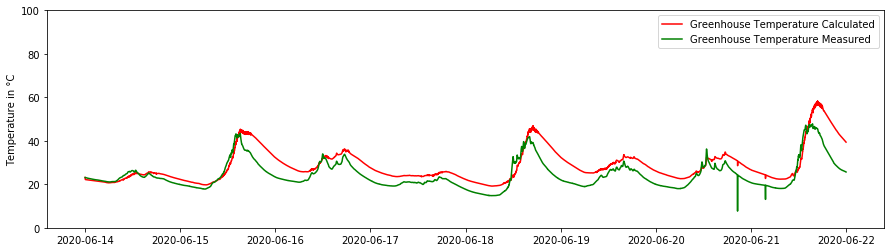

In [65]:
results = pd.DataFrame()
results['gh_temp_measured'] = measurements['gh_mean'].loc[str(start_date.value):str(end_date.value)]
results['gh_temp_calculated'] = temp_greenhouse
results['tank_temp_measured'] = measurements['tank_mean'].loc[str(start_date.value):str(end_date.value)]
results['tank_temp_calculated'] = temp_storage

time = results.index
gh_temp_measured = results[['gh_temp_measured']]
gh_temp_calculated = results[['gh_temp_calculated']]
tank_temp_measured = results['tank_temp_measured']
tank_temp_calculated = results['tank_temp_calculated']

plt.rcParams['figure.figsize'] = [15, 4]
fig, ax = plt.subplots()
ax.plot(time,gh_temp_calculated,label = 'Greenhouse Temperature Calculated', color = 'r')
ax.plot(time,gh_temp_measured, label = 'Greenhouse Temperature Measured', color = 'green')
#ax.plot(time,temp_wood, label = 'Wood Temperature Calculated', color = 'brown')
ax.set_ylim(0,100)
ax.set_ylabel('Temperature in °C')
ax.legend();

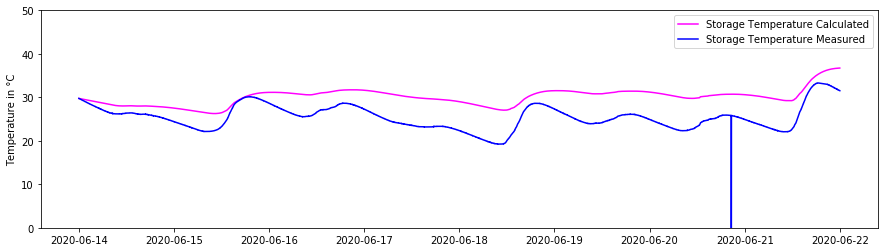

In [66]:
plt.rcParams['figure.figsize'] = [15, 4]
fig, ax = plt.subplots()
ax.plot(time,tank_temp_calculated,label = 'Storage Temperature Calculated', color = 'magenta')
ax.plot(time,tank_temp_measured, label = 'Storage Temperature Measured', color = 'blue')
#ax.plot(time,temp_wood, label = 'Wood Temperature Calculated', color = 'brown')
ax.set_ylim(0,50)
ax.set_ylabel('Temperature in °C')
ax.legend();

**Heat flow diagram**

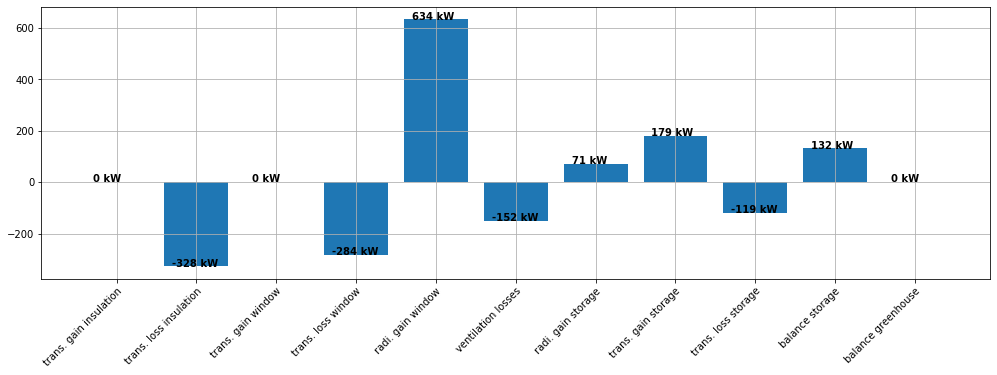

In [113]:
# plot the sum of the individual heatflows for comparisson
import matplotlib.pyplot as plt

heat_flows_sum = {'trans. gain insulation' : np.sum(np.clip(heat_flow_amb_to_greenhouse_insulation, a_min=0,a_max = np.max(heat_flow_amb_to_greenhouse_insulation)))/1000,
                  'trans. loss insulation' : np.sum(np.clip(heat_flow_amb_to_greenhouse_insulation, a_min=np.min(heat_flow_amb_to_greenhouse_insulation),a_max = 0))/1000,
                  'trans. gain window'     : np.sum(np.clip(heat_flow_amb_to_greenhouse_window,     a_min=0, a_max = np.max(heat_flow_amb_to_greenhouse_window)))/1000,
                  'trans. loss window'     : np.sum(np.clip(heat_flow_amb_to_greenhouse_window,     a_min=np.min(heat_flow_amb_to_greenhouse_window),a_max = 0))/1000,
                  'radi. gain window'     : np.sum(heat_flow_radiative_gain_air_from_sun)/1000,
                  'ventilation losses'     : np.sum(heat_flow_ventilation)/1000,
                  'radi. gain storage'    : np.sum(heat_flow_radiative_gain_storage_from_sun)/1000,
                  'trans. gain storage'    : np.sum(np.clip(heat_flow_transmission_storage_air, a_min = 0, a_max = np.max(heat_flow_transmission_storage_air)))/1000,
                  'trans. loss storage'    : np.sum(np.clip(heat_flow_transmission_storage_air, a_min = np.min(heat_flow_transmission_storage_air), a_max = 0))/1000,
                  'balance storage'    : np.sum(heat_flow_balance_storage)/1000,
                  'balance greenhouse'    : np.sum(heat_flow_balance)/1000,
                  }

y_pos = np.arange(len(heat_flows_sum))

fig, ax = plt.subplots()
ax.bar(y_pos,heat_flows_sum.values(),align='center')
#ax.xticks(rotation=90)
ax.set_xticks(y_pos)
ax.set_xticklabels(heat_flows_sum.keys())
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i, v in enumerate(heat_flows_sum.values()):
    ax.text( i -0.3 ,v, '{:.0f} kW'.format(v), fontweight='bold');

ax.grid('True');
fig.set_size_inches(17, 5)
